<h1> Initial NACOSA M&E study </h1>

In [1]:
from __future__ import division
import psycopg2
import numpy as np
import json
import re
from ast import literal_eval
import pandas as pd
import gzip
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns

from nvd3 import multiBarChart
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

from IPython.html.widgets import *

Populating the interactive namespace from numpy and matplotlib
loaded nvd3 IPython extension
run nvd3.ipynb.initialize_javascript() to set up the notebook
help(nvd3.ipynb.initialize_javascript) for options


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/Users/attiladobi/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
quarter_map={0:(0,0),1:(1,1),2:(1,2),3:(2,3),4:(2,4),5:(3,1),6:(3,2),7:(4,3),8:(4,4),9:(5,1),10:(5,2),11:(6,3),12:(6,4)}

def find_sheet_name(target_text,sheet_names):
    '''Return a list of sheet names containing a specific string'''
    return [name for name in sheet_names if target_text.lower() in name.lower()]
def find_column_name(target,columns):
    return [name for name in columns if target.lower() in name.lower()]

def month_diff(b,a):
    '''month differnece between two pandas datetime objects'''
    return (b.month - a.month + (b.year - a.year)*12)

def pq_lookup(date):
    '''retun period, quarter given a date: pd.datetime(year,month,day)'''
    #3 month index to period quarter
    #quarter_map={0:(0,0), 1:(1,1),2:(1,2),3:(2,3),4:(2,4),5:(3,1),6:(3,2),7:(4,3),8:(4,4),9:(5,1),10:(5,2),11:(6,3),12:(6,4)}
    qnum=1+int(floor(month_diff(date,pd.datetime(2016,4,1))/3))
    try:
        p,q=quarter_map[qnum]
    except KeyError:
        p,q=(0,0)
    return p,q,qnum

In [3]:
# read the entire file into a python array
#use: with open('file path','rb') as f #without gzip
with gzip.open('/Users/attiladobi/zenysis/pipeline/out/za/out/shared/20161208/za_integration.json.gz', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF = pd.read_json(data_json_str)

#convert date:
DF['Date']=pd.to_datetime(DF['Real_Date'])
DF['day'] = DF['Date'].dt.day
DF['month'] = DF['Date'].dt.month
DF['year'] = DF['Date'].dt.year

#ADD Quarter grouping to the data
DF['qNum']=[pq_lookup(date)[2] for date in DF['Date'].dt.values] #need the .dt to convert to dt index
#DF['subrecipient']=DF['subrecipient'].replace('nqobile women','nqobile')
#standardize names
#DF['field']=DF['field'].replace('red_umbrella_male_condom_lube','f_1_male_condoms_number_given')
#DF=DF.drop_duplicates()

<h1> grouped by subrecipient and quarter </h1>

In [8]:
#DF.loc[(DF['subrecipient'].str.contains("cpc")) & (DF['year']==2016)\
#      & (DF['Quarter']>0) & (DF['Quarter']<=2)].groupby(['Quarter','field']).count().dropna()

In [9]:
#DF.loc[(DF['field'].str.contains("counter_1_first_outreach_for_quarter")) & (DF['year']==2016) \
#       & (DF['Quarter']>=1) & (DF['Quarter']<=2)].keys

In [ ]:
DF.columns

In [94]:
#DF.loc[(DF['field'].str.contains("counter_1_first_outreach_for_quarter")) & (DF['year']==2016) \
#       & (DF['Quarter']>=1) & (DF['Quarter']<=2)].suburb

<h1> Count the number of unique people reached in a quarter </h1>

In [6]:
Indicator='a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach'

unique_people_per_m=DF.loc[(DF['field']==Indicator)\
                        & (DF['qNum']>0)].groupby(['subrecipient','month']).unique_id.nunique()

budget_unique_people_per_m=DF.loc[(DF['field']=='budget_'+Indicator)\
                        & (DF['qNum']>0) & (DF['qNum']<=2) ].groupby(['subrecipient','month']).val.sum()

#count_new_quarter=DF.loc[(DF['field'].str.contains("counter_1_first_outreach_for_quarter")) & (DF['year']==2016) \
#       & (DF['Quarter']>=1) & (DF['Quarter']<=2)]\
#.groupby(['Quarter','subrecipient']).beneficiary.nunique()

ind2bud=unique_people_per_m/budget_unique_people_per_m

In [7]:
unique_people_per_m

subrecipient  month
cpc           4         822
              5        1005
              6        1067
              7        1007
              8        2071
              9        2439
qlac          4           2
sweat         4         395
              5           6
              6         170
              7         172
              8         456
              9          22
              10          9
Name: unique_id, dtype: int64

<h1> Count number of PM (peer motivators) per quarter </h1>

In [23]:
unique_pm_per_m=DF.loc[(DF['field']==Indicator)\
                        & (DF['qNum']>0)].groupby(['subrecipient','month']).peer_motivator.nunique()
unique_pm_per_m

pm2bud=unique_pm_per_m/budget_unique_people_per_m

In [10]:
reached_per_pm=unique_people_per_m/unique_pm_per_m
reached_per_pm['cpc']

month
4    44.700000
5    55.217391
6    62.320000
7    35.200000
8    61.382353
9    68.500000
dtype: float64

<h1> Plot monthly trend of unique SW reached and PM(peer motivators) trained</h1>

In [11]:
import plotly.plotly as py
import plotly.graph_objs as go

In [13]:
unique_people_per_m['cpc'].index

Int64Index([4, 5, 6, 7, 8, 9], dtype='int64', name=u'month')

In [14]:
def create_trace(data,width=4,size=10,mode='lines+markers'):
    return [go.Scatter(x=data[key_name].index, y=data[key_name].values,mode=mode,name=key_name,\
                      line = dict(width=width), marker=dict(size=size))\
    for key_name in data.index.levels[0]]

In [30]:
traces=create_trace(ind2bud.dropna()*1000)
# Edit the layout #color='#7f7f7f'
layout = dict(title = 'SW Reached per budget',
              font=dict(family='Courier New, monospace', size=18),
              xaxis = dict(title = 'Month 2016'),
              yaxis = dict(title = 'New people per month per 1000(zar)'),
              )
fig = dict(data=traces, layout=layout)
py.iplot(fig, filename='line-mode')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~attdobi/0 or inside your plot.ly account where it is named 'line-mode'


In [31]:
traces=create_trace(pm2bud.dropna()*1000)
# Edit the layout #color='#7f7f7f'
layout = dict(title = 'PMs Trained per budget',
              font=dict(family='Courier New, monospace', size=18),
              xaxis = dict(title = 'Month 2016'),
              yaxis = dict(title = 'Number of peer motivators per 1000(zar)'),
              )
fig = dict(data=traces, layout=layout)
py.iplot(fig, filename='line-mode')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~attdobi/0 or inside your plot.ly account where it is named 'line-mode'


In [32]:
traces=create_trace(reached_per_pm/budget_unique_people_per_m)
# Edit the layout #color='#7f7f7f'
layout = dict(title = 'PM performance',
              font=dict(family='Courier New, monospace', size=18),
              xaxis = dict(title = 'Month 2016'),
              yaxis = dict(title = 'Number of people reached/PM'),
              )
fig = dict(data=traces, layout=layout)
py.iplot(fig, filename='line-mode')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~attdobi/0 or inside your plot.ly account where it is named 'line-mode'


<h1> Get quarterly spending data </h1>

In [42]:
plot_spend=DF.loc[(DF['field']=='spend') & (DF['year']<=2016) & (DF['Quarter']<=2)].groupby(['Quarter','subrecipient']).sum()['val']
#plot_spend

In [59]:
plot_spend

Quarter  subrecipient  
1        cpc               2.759530e+06
         htt               9.026696e+05
         lifeline nc       5.417175e+05
         ll durban         8.422708e+05
         ll fs             6.321698e+05
         ll zululand       6.386447e+05
         munna ndi nnyi    8.012208e+05
         nqobile           1.443221e+06
         oasis             1.778952e+06
         phru              1.297509e+06
         psh               7.465358e+05
         qac               1.400363e+06
         sweat             4.444029e+06
         thca              2.387249e+04
         wrhi              1.736811e+06
2        cpc               1.618566e+06
         htt               3.580400e+05
         lifeline nc       2.402625e+05
         ll durban         2.850366e+05
         ll fs             4.950573e+05
         ll zululand       2.029758e+05
         munna ndi nnyi    1.188548e+05
         nqobile           6.233507e+05
         oasis             6.631024e+05
         phru   

In [62]:
def plot_q(t):
    q=t
    #setup colors
    start,stop=0,1
    number_of_colors= len(count_new_quarter.index.levels[1])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(10, 7)
    sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.5})
    for SR,color in zip(count_new_quarter.index.levels[1],colors):
        try: 
            scatter(plot_spend[(q,SR)]/1e6,count_new_quarter[(q,SR)],color=color,label=SR,s=200)
        except KeyError:
            print('fail')

    #legend=plt.legend(frameon=True )
    #frame = legend.get_frame()
    #frame.set_facecolor('white')

    plt.ylabel('New People Reached per Quarter')
    plt.xlabel('Money Spent ($ Million)')

fail


<function __main__.plot_q>

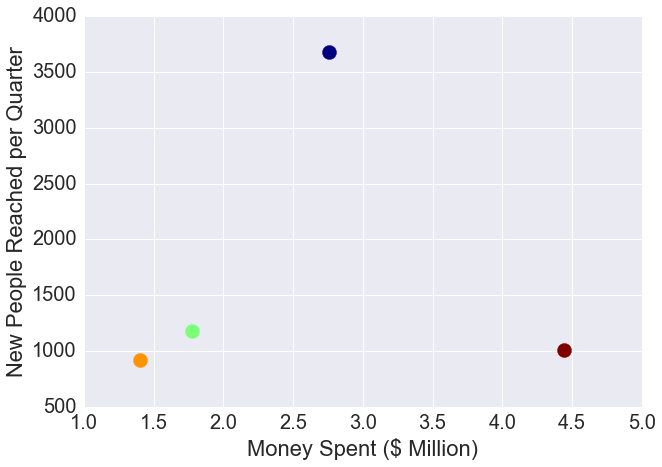

In [63]:
interact(plot_q, t=(1,2,1) )

<h1> Bar Chart for people reached normalized to money spent </h1>

In [64]:
#After cutting the data is indexed as 1 and 2 on level 1
dat=count_new_quarter/plot_spend
#dat

In [65]:
#Loop through data and build arrays for q1, q2

names=[]
q1=[]
q2=[]
for SR in count_new_quarter.index.levels[1]:
    names.append(SR)
    q1.append(dat[(1,SR)])
    q2.append(dat[(2,SR)])
q1=np.array(q1)    
q2=np.array(q2)    

In [66]:
#new
'''
q1=np.array(dat[1].values)
q2=np.array(dat[2].values)
names=dat[2].index
'''
#this will lead to an error since the first quarter has one less SR reporting

'\nq1=np.array(dat[1].values)\nq2=np.array(dat[2].values)\nnames=dat[2].index\n'

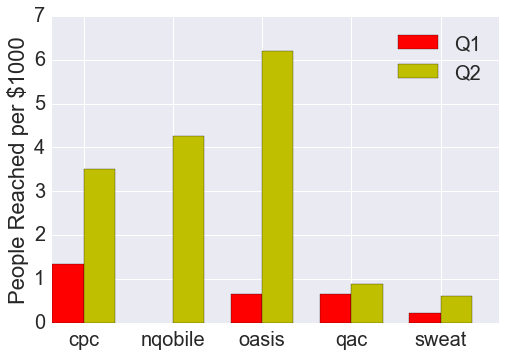

In [67]:
N = 5

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, q1*1000, width, color='r', label='Q1')

rects2 = ax.bar(ind + width, q2*1000, width, color='y',label='Q2')

# add some text for labels, title and axes ticks
ax.set_ylabel('People Reached per $1000')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(names)
plt.legend()

In [68]:
# Open File to write the D3 Graph
output_file = open('SA.html', 'w')

kwargs1 = {"fontSize": '100'}

chart = multiBarChart(width=800, height=400, x_axis_format=None, **kwargs1)
chart.create_y_axis('yAxis','People Reached per $1000')

xdata = names
#xdata = ['one' , 'two', 'three', 'four']
ydata1 = q1*1000
ydata2 = q2*1000

chart.add_serie(name="Quarter 1", y=ydata1, x=xdata ,**kwargs1)
chart.add_serie(name="Quarter 2", y=ydata2, x=xdata, **kwargs1)
chart.buildhtml()

output_file.write(chart.htmlcontent)

# close Html file
output_file.close()

<h1> People Reached per $1000 </h1>

In [58]:
def plot_ME(ME_name, title_str):
    if ME_name.split('_')[0]=='a2':
        services=DF.loc[(DF['field']==Indicator)\
                        & (DF['qNum']>0) & (DF['qNum']<=2)].groupby(['qNum','subrecipient']).unique_id.nunique()
    else:
        services=DF.loc[(DF['field']==ME_name) & (DF['year']==2016) \
                    & (DF['qNum']>0) & (DF['qNum']<=2)]\
        .groupby(['qNum','subrecipient']).sum().val

    budget_ind=DF.loc[(DF['field']=='budget_'+ME_name)\
                        & (DF['qNum']>0) & (DF['qNum']<=2) ].groupby(['qNum','subrecipient']).val.sum()


    services_per_spend=services/budget_ind

    names=[]
    q1=[]
    q2=[]
    for SR in services.index.levels[1]:
        names.append(SR)
        q1.append(services_per_spend[(1,SR)])
        q2.append(services_per_spend[(2,SR)])
    q1=np.array(q1)    
    q2=np.array(q2) 


    # Open File to write the D3 Graph
    output_file = open('SA_services.html', 'w')

    kwargs1 = {"fontSize": '100'}

    chart = multiBarChart(name=ME_name, width=800, height=400, x_axis_format=None, **kwargs1)
    chart.create_y_axis('yAxis',title_str+' per 1000(ZAR)')

    xdata = names
    #xdata = ['one' , 'two', 'three', 'four']
    ydata1 = q1*1000
    ydata2 = q2*1000

    chart.add_serie(name="Quarter 1", y=ydata1, x=xdata ,**kwargs1)
    chart.add_serie(name="Quarter 2", y=ydata2, x=xdata, **kwargs1)

    chart.buildhtml()

    output_file.write(chart.htmlcontent)

    # close Html file
    output_file.close()

    display(chart)

<h1> b2_sw_tested_hiv_negative </h1>

In [52]:
plot_ME('f1_number_of_male_condoms_distributed','f1 condoms distributed')

<h1> People reached </h1>

In [59]:
plot_ME('a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach', 'SW reached')

<h1> b1 </h1>

In [60]:
plot_ME('b1_number_of_sex_workers_that_have_received_an_hiv_test_during_the_reporting_period_and_know_their_results'\
        ,'b1 recived HIV test and know results')

<h1> e2 </h3>

In [66]:
plot_ME('e2_number_of_sex_workers_attending_creative_space_workshops','e2 SW attending workshops')

<h1> Risk reduction workshop </h1>

In [73]:
plot_ME('risk_reduction_workshop')

<h1> d1_number_of_sws_screened_for_tb </h1>

In [74]:
plot_ME('d1_number_of_sws_screened_for_tb')

<h1> c1_sws_screened_for_sexually_transmitted_infections_sti_2 </h1>

In [75]:
plot_ME('c1_sws_screened_for_sexually_transmitted_infections_sti_2')

<h1> f_1_male_condoms_number_given </h1>

In [76]:
plot_ME('f_1_male_condoms_number_given')

<h1> b_1_received_hts_and_know_results </h1>

In [11]:
plot_ME('b_1_received_hts_and_know_results')

NameError: name 'plot_ME' is not defined

<h1> ... next we'd also like to normalize to targets </h1>